# Bank Marketing — EDA + Logistic Regression (from scratch)

This notebook uses `bank-full.csv` (provided at `/mnt/data/bank-full.csv`) to:

1. Perform Exploratory Data Analysis (EDA)
2. Preprocess the data
3. Split into train/test (80:20, shuffled)
4. Implement Logistic Regression from scratch (gradient descent with L2)
5. Train and evaluate using classification metrics implemented from scratch
6. Compare with scikit-learn's `LogisticRegression` for reference


In [1]:
# Cell 2: imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Cell 3: Load the dataset (path provided)
csv_path = 'bank-full.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found. Make sure the file is uploaded to that path.")

df = pd.read_csv(csv_path, sep=';')
print('Loaded dataset shape:', df.shape)
df.head()


Loaded dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Cell 4: Basic EDA
print('--- dtypes ---')
display(df.dtypes.to_frame('dtype'))

print('\\n--- Numerical summary ---')
display(df.describe().T)

print('\\n--- Categorical unique counts ---')
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
display(df[cat_cols].nunique().sort_values(ascending=False).to_frame('unique_values'))

print('\\n--- Missing values per column ---')
display(df.isnull().sum().to_frame('missing'))

print('\\n--- Target (y) distribution ---')
display(df['y'].value_counts().to_frame('count'))


--- dtypes ---


,dtype
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


\n--- Numerical summary ---


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


\n--- Categorical unique counts ---


,unique_values
job,12
month,12
poutcome,4
education,4
marital,3
contact,3
loan,2
housing,2
default,2
y,2


\n--- Missing values per column ---


,missing
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


\n--- Target (y) distribution ---


,count
y,
no,39922
yes,5289


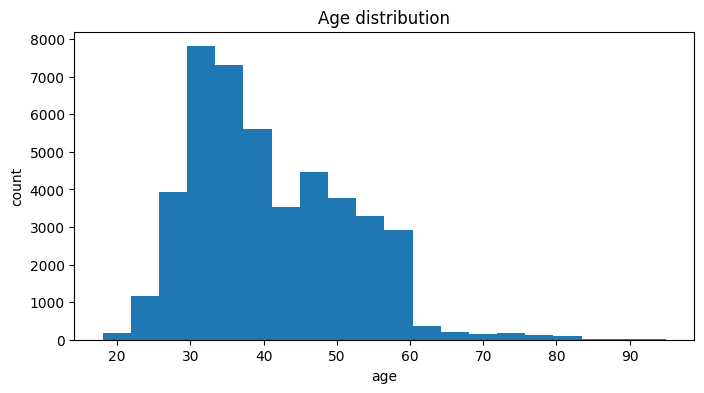

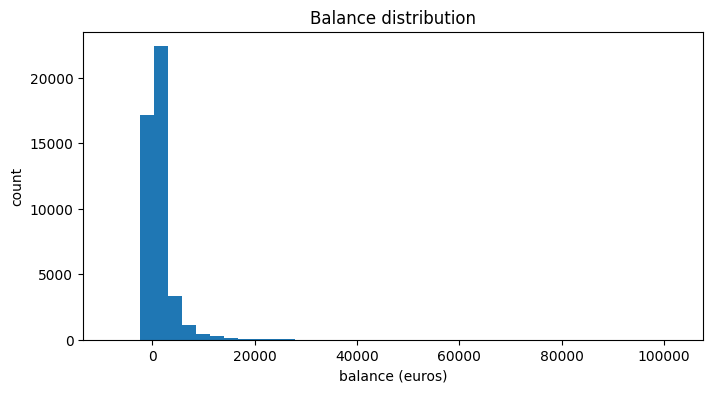

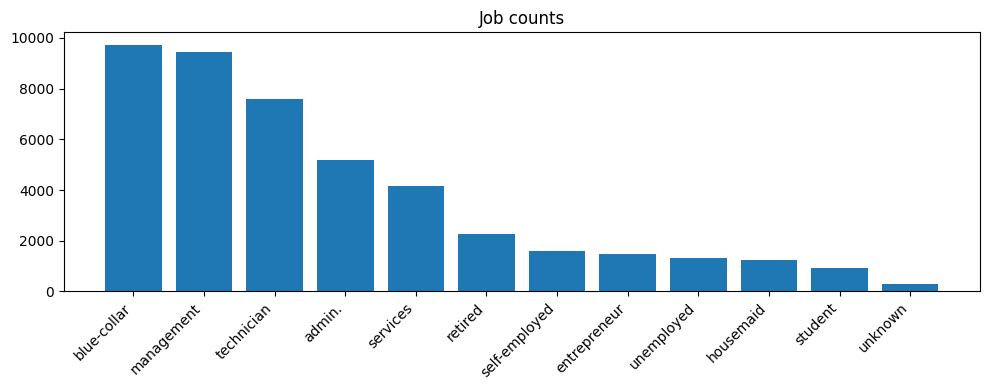

In [4]:
# Cell 5: Visualizations using matplotlib
plt.figure(figsize=(8,4))
plt.hist(df['age'], bins=20)
plt.title('Age distribution')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['balance'], bins=40)
plt.title('Balance distribution')
plt.xlabel('balance (euros)')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(10,4))
job_counts = df['job'].value_counts()
plt.bar(job_counts.index, job_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Job counts')
plt.tight_layout()
plt.show()


In [5]:
# ======================================
# Cell 6 — Data Preprocessing Function
# ======================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

def preprocess(df, drop_duration=True):
    df_proc = df.copy()

    # Drop duration for realistic modeling
    if drop_duration and 'duration' in df_proc.columns:
        df_proc = df_proc.drop(columns=['duration'])

    # Separate target variable
    y = df_proc['y'].map({'yes': 1, 'no': 0})
    df_proc = df_proc.drop(columns=['y'])

    # Handle unknown / missing placeholders
    df_proc.replace(['unknown'], np.nan, inplace=True)

    # Fill missing numeric and categorical values
    for col in df_proc.select_dtypes(include=['object']).columns:
        df_proc[col].fillna(df_proc[col].mode()[0], inplace=True)
    for col in df_proc.select_dtypes(include=['int64', 'float64']).columns:
        df_proc[col].fillna(df_proc[col].median(), inplace=True)

    # Separate categorical and numeric columns
    cat_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

    # OneHotEncode categorical (drop first to reduce collinearity)
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_cat = ohe.fit_transform(df_proc[cat_cols]) if len(cat_cols)>0 else np.empty((len(df_proc),0))
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols)>0 else []

    # Standardize numeric features
    num_cols = df_proc.select_dtypes(include=['int64', 'float64']).columns.tolist()
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df_proc[num_cols]) if len(num_cols)>0 else np.empty((len(df_proc),0))

    # Concatenate all features
    X = np.hstack([X_num, X_cat])
    feature_names = num_cols + cat_feature_names

    return X, y, feature_names, ohe, scaler

# Prepare the realistic dataset (drop duration)
X_real, y_real, feat_names_real, ohe_real, scaler_real = preprocess(df, drop_duration=True)
print('Realistic dataset shape (no duration):', X_real.shape)


Realistic dataset shape (no duration): (45211, 37)


C:\Users\Vishal Gautam\AppData\Local\Temp\ipykernel_27560\2628487993.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_proc[col].fillna(df_proc[col].mode()[0], inplace=True)
C:\Users\Vishal Gautam\AppData\Local\Temp\ipykernel_27560\2628487993.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [6]:
# Cell 7: Train/test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (36168, 37) Test shape: (9043, 37)


In [7]:
# Cell 8: Logistic Regression implemented from scratch
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, n_iter=1000, fit_intercept=True, verbose=False, reg_lambda=0.0):
        self.lr = lr
        self.n_iter = n_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.reg_lambda = reg_lambda
    
    def _add_intercept(self, X):
        if self.fit_intercept:
            intercept = np.ones((X.shape[0], 1))
            return np.hstack((intercept, X))
        return X
    
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = self._add_intercept(X)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        for i in range(self.n_iter):
            z = X.dot(self.w)
            preds = self._sigmoid(z)
            error = preds - y
            grad = (X.T.dot(error)) / n_samples
            # L2 regularization (do not regularize intercept)
            if self.reg_lambda > 0:
                reg = np.concatenate(([0], self.reg_lambda * self.w[1:] / n_samples))
                grad += reg
            self.w -= self.lr * grad
            if self.verbose and (i % max(1, (self.n_iter // 10)) == 0):
                loss = -np.mean(y*np.log(preds+1e-12) + (1-y)*np.log(1-preds+1e-12))
                print(f"Iter {i}/{self.n_iter}, loss: {loss:.5f}")
        return self
    
    def predict_proba(self, X):
        X = self._add_intercept(X)
        return self._sigmoid(X.dot(self.w))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [8]:
# Cell 9: Train (you can tune lr, n_iter, reg_lambda)
model = LogisticRegressionScratch(lr=0.5, n_iter=2000, verbose=True, reg_lambda=0.01)
model.fit(X_train, y_train)
print('Training finished.')


Iter 0/2000, loss: 0.69315
Iter 200/2000, loss: 0.31391
Iter 400/2000, loss: 0.30825
Iter 600/2000, loss: 0.30613
Iter 800/2000, loss: 0.30518
Iter 1000/2000, loss: 0.30471
Iter 1200/2000, loss: 0.30445
Iter 1400/2000, loss: 0.30431
Iter 1600/2000, loss: 0.30422
Iter 1800/2000, loss: 0.30417
Training finished.


In [9]:
# Cell 10: Evaluation metrics implemented from scratch
def confusion_matrix_from_scratch(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return np.array([[tn, fp],[fn, tp]])

def accuracy_from_scratch(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_from_scratch(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall_from_scratch(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_from_scratch(y_true, y_pred):
    p = precision_from_scratch(y_true, y_pred)
    r = recall_from_scratch(y_true, y_pred)
    return 2*p*r / (p + r) if (p + r) > 0 else 0.0

# Predict on test
y_prob_test = model.predict_proba(X_test)
y_pred_test = model.predict(X_test)

cm = confusion_matrix_from_scratch(y_test, y_pred_test)
acc = accuracy_from_scratch(y_test, y_pred_test)
prec = precision_from_scratch(y_test, y_pred_test)
rec = recall_from_scratch(y_test, y_pred_test)
f1 = f1_from_scratch(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_prob_test)

print('Confusion matrix (tn, fp; fn, tp):')
print(cm)
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


Confusion matrix (tn, fp; fn, tp):
[[7859   93]
 [ 899  192]]
Accuracy: 0.8903
Precision: 0.6737
Recall: 0.1760
F1-score: 0.2791
ROC AUC: 0.7409


In [10]:
# Cell 11: scikit-learn comparator
sk_model = SklearnLogisticRegression(max_iter=1000, solver='lbfgs')
sk_model.fit(X_train, y_train)

y_prob_sk = sk_model.predict_proba(X_test)[:,1]
y_pred_sk = sk_model.predict(X_test)

print('Sklearn confusion matrix:\\n', confusion_matrix(y_test, y_pred_sk))
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Sklearn Accuracy:', accuracy_score(y_test, y_pred_sk))
print('Sklearn Precision:', precision_score(y_test, y_pred_sk))
print('Sklearn Recall:', recall_score(y_test, y_pred_sk))
print('Sklearn F1:', f1_score(y_test, y_pred_sk))
print('Sklearn ROC AUC:', roc_auc_score(y_test, y_prob_sk))


Sklearn confusion matrix:\n [[7860   92]
 [ 897  194]]
Sklearn Accuracy: 0.8906336392790003
Sklearn Precision: 0.6783216783216783
Sklearn Recall: 0.1778185151237397
Sklearn F1: 0.28177196804647786
Sklearn ROC AUC: 0.7400200930606554


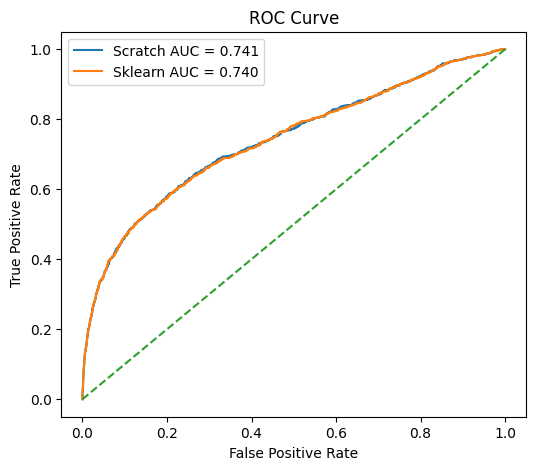

In [11]:
# Cell 12: ROC curve
fpr_s, tpr_s, _ = roc_curve(y_test, y_prob_test)
fpr_sk, tpr_sk, _ = roc_curve(y_test, y_prob_sk)
auc_s = auc(fpr_s, tpr_s)
auc_sk = auc(fpr_sk, tpr_sk)

plt.figure(figsize=(6,5))
plt.plot(fpr_s, tpr_s, label=f'Scratch AUC = {auc_s:.3f}')
plt.plot(fpr_sk, tpr_sk, label=f'Sklearn AUC = {auc_sk:.3f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [12]:
# Cell 13: Save the trained models (optional)
import joblib
os.makedirs('/mnt/data/models', exist_ok=True)
joblib.dump(model, '/mnt/data/models/logreg_scratch.pkl')
joblib.dump(sk_model, '/mnt/data/models/logreg_sklearn.pkl')
print('Saved scratch and sklearn models to /mnt/data/models/')


Saved scratch and sklearn models to /mnt/data/models/
